In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#load VAR parameter values from excel sheet
VAR_param = pd.read_excel('VAR_param.xlsx', index_col=0)
VAR_param

,Real NOK 70-30,Real NOK 50-50,Real USD 70-30,Real USD 50-50
r_0,0.063200,0.058200,0.049100,0.044100
a_1,-0.037500,-0.037300,-0.059900,-0.075600
a_2,1.192300,1.923100,1.992000,1.204300
a_3,-0.506900,-0.515700,-0.489200,-0.496900
b_1,1.082700,1.084700,1.073100,1.069400
b_2,-0.295000,-0.297800,-0.283500,-0.283700
std_r,0.138900,0.116800,0.123900,0.093400
std_x,0.017100,0.017600,0.015700,0.016000
std_f,0.021800,0.021800,0.021900,0.021900
cov_xf,0.000148,0.000155,0.000119,0.000132


In [3]:
#prepare parameter values
r_0, a_1, a_2, a_3, b_1, b_2, std_r, std_x, std_f, cov_xf = VAR_param['Real USD 70-30'][:-1]

r_mean = 0.03
mu = np.log(1+r_mean)

cov_e = [[std_r**2, 0, 0],
        [0, std_x**2, cov_xf],
        [0, cov_xf, std_f**2]]


In [4]:
#simulation

#generate random errors
sample_size = 1000000
T = 40 #years
e = np.random.multivariate_normal([0,0,0], cov_e, (T, sample_size))

In [5]:
#simulate the VAR
r = np.zeros((T, sample_size))
X = np.zeros((T, sample_size))
F = np.zeros((T, sample_size))

#first simulate r because it is independent
r = mu -.5*std_r**2 + e[:,:,0]
#then simulate X and F
#note that the first couple of values are taken from end of arrays
for t in range(T):
    X[t] = a_1*r[t-1] + a_2*X[t-1] + a_3*X[t-2] + e[t,:,1]
    F[t] = b_1*F[t-1] + b_2*F[t-2] + e[t,:,2]

In [6]:
#simulate withdrawal rules
df = pd.DataFrame(index = ['5%', '25%', '50%', '75%', '95%', 'Mean','Depletion rate']) #table to save results to

#simulation paramaters
params = [{'lambda':0, 'F':False, 'X':False},
          {'lambda':0, 'F':False, 'X':True},
          {'lambda':0, 'F':True, 'X':True},
         {'lambda':0.5, 'F':True, 'X':True},
         {'lambda':0.8, 'F':True, 'X':True}]

for param in params:
    lambda_ = param['lambda']
    A = np.zeros((T, sample_size))
    D = np.zeros((T, sample_size))
    S = np.zeros((T, sample_size))
    A[0] = 10
    S[0] = r_mean*A[0]
    D[0] = S[0] + X[0]*param['X'] + F[0]*param['F']
    for t in range(1,T):
        A[t] = np.maximum(A[t-1]*np.exp(r[t-1])-D[t-1], 0)

        S[t] = np.where(S[t-1]<=r_mean*A[t-1], r_mean*A[t]+F[t]*param['F'], lambda_*S[t-1]+(1-lambda_)*r_mean*A[t]+F[t]*param['F']) 
        D[t] = S[t] + X[t]*param['X']

    df[r'$\lambda$={}, X={}, F={}'.format(param['lambda'], param['X'], param['F'])] = [np.percentile(A[-1], 5),np.percentile(A[-1], 25), np.percentile(A[-1], 50), np.percentile(A[-1], 75), np.percentile(A[-1], 95), A[-1].mean(),(A[-1]==0).mean()]



In [7]:
df

,"$\lambda$=0, X=False, F=False","$\lambda$=0, X=True, F=False","$\lambda$=0, X=True, F=True","$\lambda$=0.5, X=True, F=True","$\lambda$=0.8, X=True, F=True"
5%,1.952814,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.250489,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.273421,5.875489e+06,5.875488e+06,5.889952e+06,5.899531e+06
75%,12.461763,3.263728e+07,3.263728e+07,3.271466e+07,3.276166e+07
95%,27.055283,7.197384e+07,7.197384e+07,7.214602e+07,7.224666e+07
Mean,10.004397,1.907100e+07,1.907100e+07,1.911736e+07,1.914518e+07
Depletion rate,0.000000,4.409080e-01,4.409080e-01,4.409080e-01,4.409080e-01


Text(0, 0.5, 'X')

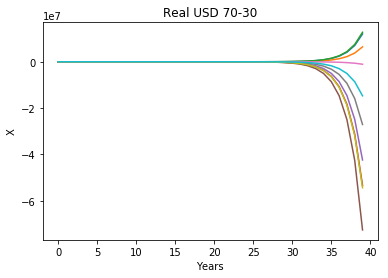

In [12]:
plt.plot(X[:,:10])
plt.title('Real USD 70-30')
plt.xlabel('Years')
plt.ylabel('X')